The goal of the following work is to use machine learning to figure out key indicators to tell whether a signed_up driver will
complete their first trip and make suggestions to increase the completion rate of the signed_up drivers.

Please see TApp_StatisticalAnalysis.ipynb for statistical analysis of the data and correlation relationship between different features and whether the drivers completed their first trip or not within 30 days.

### Import Data
The imported data is the exported data from TApp_StatisticalAnalysis.ipynb.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

%matplotlib inline

In [2]:
data = pd.read_csv('analyzed_data.csv')

In [3]:
data.head(5)

,Unnamed: 0,vehicle_year,city,os,channel,signup_bgc,signup_vehicle_added,signup_first_completed,bgc_vehicle_added,completed
0,0,NaN,1,1.0,1,NaN,NaN,NaN,NaN,0
1,1,NaN,1,3.0,1,NaN,NaN,NaN,NaN,0
2,2,NaN,3,3.0,2,0.0,NaN,NaN,NaN,0
3,3,2016.0,2,2.0,3,5.0,5.0,5.0,0.0,1
4,4,2016.0,1,2.0,3,15.0,16.0,NaN,1.0,0


Drop the index column and other two columns which won't be used in the following machine learning algorithms.

In [4]:
data = data.drop(['Unnamed: 0', 'signup_first_completed', 'bgc_vehicle_added'], axis = 1)

Map os missing values into categorical value

In [5]:
data['os'] = data['os'].fillna(6) 

Map vehicle_year, signup_bgc, signup_vehicle_added into categorical value 0 or 1

In [6]:
data['vehicle_year'] = data['vehicle_year'].map(lambda x: 1 if x >= 0 else 0) 
data['signup_bgc'] = data['signup_bgc'].map(lambda x: 1 if x >= 0 else 0) 
data['signup_vehicle_added'] = data['signup_vehicle_added'].map(lambda x: 1 if x >= 0 else 0) 

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54681 entries, 0 to 54680
Data columns (total 7 columns):
vehicle_year            54681 non-null int64
city                    54681 non-null int64
os                      54681 non-null float64
channel                 54681 non-null int64
signup_bgc              54681 non-null int64
signup_vehicle_added    54681 non-null int64
completed               54681 non-null int64
dtypes: float64(1), int64(6)
memory usage: 2.9 MB


### Convert categorical variables into dummy/indicator variables

In [8]:
def process_dummies(name, newname):
    global data
    newname = pd.get_dummies(data[name], prefix=name)
    data = pd.concat([data,newname], axis=1)
    data.drop(name, axis=1, inplace=True)
    

In [9]:
process_dummies('os', 'new_os')
process_dummies('city', 'new_city')
process_dummies('channel', 'new_channel')

In [10]:
data.head(5)

,vehicle_year,signup_bgc,signup_vehicle_added,completed,os_1.0,os_2.0,os_3.0,os_4.0,os_5.0,os_6.0,city_1,city_2,city_3,channel_1,channel_2,channel_3
0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
2,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0
3,1,1,1,1,0,1,0,0,0,0,0,1,0,0,0,1
4,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1


### Correlation Matrix of all columns in the dataset.
Result here will be compared with the following machine learning results.

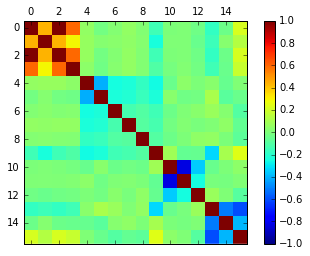

In [11]:
fig = plt.figure()
# subplot grid parameters encoded as a single integer.
# For example, "111" means "1x1 grid, first subplot" and "234" means "2x3 grid, 4th subplot".
# Alternative form for add_subplot(111) is add_subplot(1, 1, 1).
ax = fig.add_subplot(111)  
cax = ax.matshow(data.corr(), vmin = -1, vmax = 1, interpolation = 'none')
fig.colorbar(cax)
plt.show()

It's obvious that the 'completed' column is closedly related to the first three columns: 'vehicle_year', 'signup_bgc'
and 'signup_vehicle_added'. But correlation doesn't necessarily mean causation. Let's figure out causation using machine learning.

### Test/Train Data Split

In [12]:
y = data['completed']
data = data.drop(['completed'], axis = 1)
x = data.values

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.3, random_state = 7)

### Decision Trees
Previous experience tells me that decision trees model is a good try to start with.

In [13]:
parameter = {'criterion':['entropy', 'gini'],'max_features':[1, 2, 3]} 

clf = DecisionTreeClassifier(random_state = 7)
grid_search = GridSearchCV(estimator=clf, param_grid=parameter,scoring ='neg_log_loss', verbose=1, cv=10)
grid_search.fit(train_x, train_y)
for score in grid_search.grid_scores_:
    print('This is score: ', score)

output = grid_search.predict(test_x)
testaccuracy = accuracy_score(test_y, output)
print('This is test accuracy: ', testaccuracy)  

Fitting 10 folds for each of 6 candidates, totalling 60 fits
This is score:  mean: -0.19203, std: 0.01440, params: {'max_features': 1, 'criterion': 'entropy'}
This is score:  mean: -0.19298, std: 0.01547, params: {'max_features': 2, 'criterion': 'entropy'}
This is score:  mean: -0.19380, std: 0.01451, params: {'max_features': 3, 'criterion': 'entropy'}
This is score:  mean: -0.19203, std: 0.01440, params: {'max_features': 1, 'criterion': 'gini'}
This is score:  mean: -0.19298, std: 0.01547, params: {'max_features': 2, 'criterion': 'gini'}
This is score:  mean: -0.19200, std: 0.01439, params: {'max_features': 3, 'criterion': 'gini'}
This is test accuracy:  0.894483389211


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    3.0s finished
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


#### Get importance of features in the decision tree classifier. 
The higher the value, the more important the feature. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance. 

Every time a split of a node is made on variable m the gini impurity criterion for the two descendent nodes is less than the 
parent node. Adding up the gini decreases for each individual variable over all trees in the forest gives a fast variable 
importance which is called Gini importance.

In [14]:
grid_search.best_estimator_.feature_importances_

array([ 0.827499  ,  0.02896395,  0.03902152,  0.00430091,  0.00424533,
        0.00196494,  0.00295934,  0.00090243,  0.01816635,  0.0016459 ,
        0.00361833,  0.00091046,  0.04868431,  0.01083682,  0.00628041])

The top four most important features are vehicle_year(0.827499), channel_1 (0.04868431), signup_vehicle_added (0.03902152), signup_bgc(0.02896395). These results are in good agreement with the correlation map shown above.

This method gives a prediction accuracy on the test data of 89.4%, which is quite decent. Let's try two other ensemble methods such as Random Forest or XGBoosting to see whether we can get more accurate prediction on 'completion' or not.

### Random Forest Model
Ensemble method based on decision trees. It usually perform better than single decision tree.

In [15]:
from sklearn.ensemble import RandomForestClassifier
N = [50, 100, 150]
testaccuracy = []
logloss = []
best_parameters = []
for i in range(len(N)):
    parameter = {'criterion':['entropy', 'gini'],'max_features':[1, 2, 3]}
    clf = RandomForestClassifier(n_estimators = N[i])
    grid_search = GridSearchCV(estimator=clf, param_grid=parameter, 
                                     scoring ='neg_log_loss', verbose=1, cv=20) 
    grid_search.fit(train_x, train_y)

    output3 = grid_search.predict(test_x)
    testaccuracy.append(accuracy_score(test_y, output3))
    logloss.append(grid_search.best_score_)
    best_parameters.append( grid_search.best_params_ )

print("This is testaccuracy:", testaccuracy)
print("This is logloss:", logloss)

Fitting 20 folds for each of 6 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.8min finished


Fitting 20 folds for each of 6 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  3.3min finished


Fitting 20 folds for each of 6 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  5.0min finished


This is testaccuracy: [0.89399573300822921, 0.89448338921060655, 0.89448338921060655]
This is logloss: [-0.18729838425259235, -0.18725671585539175, -0.18728364787719037]


In [16]:
grid_search.best_estimator_.feature_importances_

array([ 0.38312701,  0.10980233,  0.42470125,  0.00287724,  0.00365527,
        0.00315925,  0.00385645,  0.00188086,  0.01856516,  0.00285487,
        0.00279751,  0.00253751,  0.01352184,  0.00532578,  0.02133766])

Random Forest classifier offers similar prediction accuracy (89.4%) as decision tree classifier.

It provides the top four important features: vehicle_year(0.41581213), signup_vehicle_added (0.40078183), signup_bgc (0.08047989), channel_3(0.03332108). This is in good agreement with results from decision trees algorithm.

### XGBoost

In [17]:
from xgboost import XGBClassifier
from xgboost import plot_importance

# fit model no training data
model = XGBClassifier()

# monitor performance and early termination
eval_set = [(test_x, test_y)]
model.fit(train_x, train_y, early_stopping_rounds = 10, eval_metric = "error", eval_set = eval_set, verbose = True)

# use error evaluation to stop training once no further improvements have been made to the model.
model.fit(train_x, train_y)

# make predictions for test data
y_pred = model.predict(test_x)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(test_y, predictions)
print("Accuracy: %.2f%%"%(accuracy*100.0))

[0]	validation_0-error:0.108321
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.108321
[2]	validation_0-error:0.108321
[3]	validation_0-error:0.105578
[4]	validation_0-error:0.105578
[5]	validation_0-error:0.105578
[6]	validation_0-error:0.105578
[7]	validation_0-error:0.105578
[8]	validation_0-error:0.105578
[9]	validation_0-error:0.105578
[10]	validation_0-error:0.105578
[11]	validation_0-error:0.105578
[12]	validation_0-error:0.105578
[13]	validation_0-error:0.105578
Stopping. Best iteration:
[3]	validation_0-error:0.105578

Accuracy: 89.54%


XGBoost gives similar accuracy as decisiont trees and random forests models.

[ 0.10722101  0.28446388  0.05908096  0.02844639  0.0547046   0.03063457
  0.04376367  0.02188184  0.0809628   0.03501094  0.01750547  0.03501094
  0.09628009  0.01750547  0.08752735]


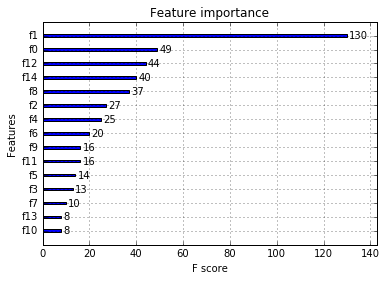

In [18]:
print(model.feature_importances_)
plot_importance(model)
plt.show()

The most important features in XGBoost is signup_bgc (0.28446388), vehicle_year (0.10722101), channel_1 (0.09628009) and channel_3 (0.08752735).

### Summary from the above three machine learning algorithms:

- Decision trees, random forests and XGBoost gives similar prediction accuracy on the tetsting data: 89.5%. While there may be 
  still room for improving the prediction accuracy using other machine learning algorithms, we are quite satisfied with the 
  current prediction results and won't spend more time optimizing it.
    
- All these three models predicted that bgc, vehicle_year, vehicle_added and channel are most important features. So let's visualize these features to get a better understanding of the cause-and-effect relationship.

### Visualize key features

Plot vehicle_year (not added: 0 or added: 1) vs completed

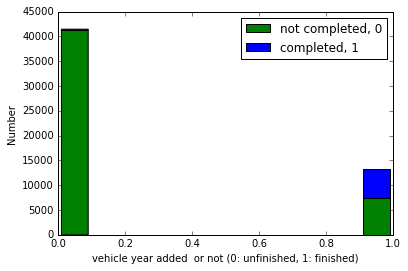

In [19]:
data['completed'] = y
plt.hist([data[data['completed'] == 0]['vehicle_year'], data[data['completed'] == 1]['vehicle_year']], stacked = True, 
         color = ['g','b'], label = ['not completed, 0', 'completed, 1'])
plt.legend()
plt.xlabel('vehicle year added  or not (0: unfinished, 1: finished)')
plt.ylabel('Number')
plt.show()

In [20]:
data[data['vehicle_year'] == 0]['completed'].value_counts()

0    41194
1      264
Name: completed, dtype: int64

In [21]:
data[data['vehicle_year'] == 1]['completed'].value_counts()

0    7350
1    5873
Name: completed, dtype: int64

For signed_up drivers, only 264/(264+41194) = 0.6% of those who didn't added their vehicle year completed their first trip, 
while 5873/(5873+7350) = 44.4% of those who did completed their first trip. 

Plot signup_vehicle_added (not added: 0 or added: 1) vs completed

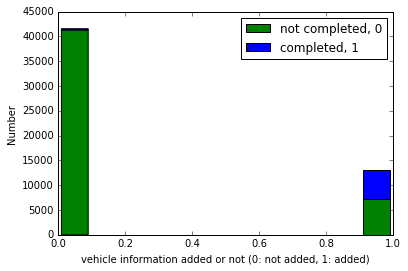

In [22]:
plt.hist([data[data['completed'] == 0]['signup_vehicle_added'], data[data['completed'] == 1]['signup_vehicle_added']], stacked = True, 
         color = ['g','b'], label = ['not completed, 0', 'completed, 1'])
plt.legend()
plt.xlabel('vehicle information added or not (0: not added, 1: added)')
plt.ylabel('Number')
plt.show()

In [23]:
data[data['signup_vehicle_added'] == 0]['completed'].value_counts()

0    41282
1      266
Name: completed, dtype: int64

In [24]:
data[data['signup_vehicle_added'] == 1]['completed'].value_counts()

0    7262
1    5871
Name: completed, dtype: int64

For signed_up drivers, only 266/(266+41282) = 0.6% of those who didn't added their vehicle information completed their first trip, 
while 5871/(5871+7262) = 44.7% of those who did completed their first trip. 

Plot signup_bgc (not added: 0 or added: 1) vs completed

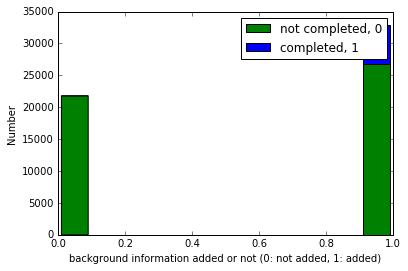

In [25]:
plt.hist([data[data['completed'] == 0]['signup_bgc'], data[data['completed'] == 1]['signup_bgc']], stacked = True, 
         color = ['g','b'], label = ['not completed, 0', 'completed, 1'])
plt.legend()
plt.xlabel('background information added or not (0: not added, 1: added)')
plt.ylabel('Number')
plt.show()

In [26]:
data[data['signup_bgc'] == 0]['completed'].value_counts()

0    21785
Name: completed, dtype: int64

In [27]:
data[data['signup_bgc'] == 1]['completed'].value_counts()

0    26759
1     6137
Name: completed, dtype: int64

For signed_up drivers, those who didn't added their background consent never completed their first trip, while 6137/(6137+26759) 
= 18.7% of those who did completed their first trip.

From previous statistical analysis, we know that the percentage of completed drivers among three different sign-up methods are
Referral: 19.9%, Organic: 9.0%, Paid: 6.2%. Using machine learning methods, we know that channel_1(Paid) and channel_3(Referral) plays a big role in predicting whether the signed_up drivers would finish their first trip or not. These observations are in good agreement.

### Summary

- Decision trees, random forests and XGBoost give similar prediction accuracy on the testing data: 89.5%. While there may be 
  still room for improving the prediction accuracy using other machine learning algorithms, we are quite satisfied with the 
  current prediction results.

- All these three models predicted that bgc, vehicle_year, vehicle_added and channel are most important features. 
  - Statistical analysis of these features showed that signed_up drivers who didn't add their vehicle year, or vehicle information or background consent are unlikely to complete their first trip. These drivers should be recognized early and sent reminders 
    before the 30-day deadline in order to improve their possiblity to complete the first trip.
  - Drivers signed up by referral are two and three times more likely to complete their first trip compared to those signed up by
    organic or paid method, respectively. Therefore, signing up by referral should be highly encouraged and promoted in order to 
    increase the probability for signed_up drivers to complete their first trip.